Run on kaggle TPUv3-8

# Scaling Up GPT Across Multiple Devices: Training with JAX on TPU

This project demonstrates how to build and train a GPT model using JAX and its supporting libraries, while scaling the training process across multiple compute devices. We leverage Google’s TPUv3-8, available through Kaggle, as the primary computation backend.

A TPUv3-8 consists of 8 TPU cores, each equipped with high-bandwidth memory and designed specifically for large-scale machine learning workloads. In terms of raw compute power and memory bandwidth, a single TPUv3-8 pod is roughly equivalent to eight NVIDIA V100 16GB GPUs. TPUs are highly optimized for matrix operations and large-batch parallelism, making them ideal for training transformer-based models like GPT efficiently at scale.

# Environment Setup and Imports

This section sets up the environment and imports all required libraries for high-performance machine learning using JAX, Flax, and Optax. These libraries together form a powerful, modular, and scalable ecosystem for research and production.

We will use:
- **JAX** for accelerated numerical computing. JAX, developed by Google, extends NumPy with automatic differentiation (autograd) and just-in-time (JIT) compilation, enabling execution on GPU and TPU.
- **Flax** for neural network modeling. Flax is a high-level neural network library built on top of JAX, offering a flexible functional core and powerful module abstraction for defining deep learning models.
- **Optax** for optimization and loss functions. Optax provides a composable set of gradient transformation utilities and stateful optimizers, designed to integrate seamlessly with JAX and Flax.

**Key Features:**
- JAX enables fast, scalable computation on CPU, GPU, and TPU.
- Flax provides modular, extensible neural network components.
- Optax offers flexible, composable optimization tools for training neural networks.

In [1]:
import jax.numpy     as jnp
import jax.random    as random
import jax.tree_util as jtree
from jax import grad, jit, vmap
from jax.sharding import Mesh, NamedSharding
from jax.sharding import PartitionSpec as P 
import jax

In [2]:
import optax
import flax
from flax import nnx

In [3]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from IPython.display import display, clear_output

# Hyperparameters and Device Setup

In this section, we define key model and training hyperparameters such as context size, embedding dimensions, and attention head configurations. We also configure the TPU device mesh to enable parallel training across TPU cores.

In [4]:
CONTEXT_SIZE = 1024 # 上下文長度 / Context window size
EMBED_DIM = 2048 # 嵌入維度 / Embedding dimension
QKV_DIM = 128 # QKV 向量維度 / QKV feature dimension
HEAD_SIZE = 16 # 注意力頭數 / Number of attention heads
BLOCK_SIZE = 48 # 解碼器模塊數 / Number of decoder blocks

MICRO_BATCH_SIZE = 16 # Batch size per iter 
GLOBAL_BATCH_SIZE = 64 # Batch size per step 

LEARING_RATE = 1e-7
MOMENTUM = 0.9 # Momentum factor for optimizer

train_steps = 10000
eval_every = 100

# Assertion to ensure attention dimensions match
assert QKV_DIM*HEAD_SIZE == EMBED_DIM

In [5]:
# List all local JAX devices (TPU cores)
jax.local_devices()

E0000 00:00:1748179650.612986      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230


[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [6]:
# TPU device mesh and Sharding strategy for tensor/model parallelism

# Number of available TPU cores
num_device = len(jax.local_devices()) 

# Create a mesh with axis names for logical partitioning
mesh = Mesh(devices=np.array(jax.devices()).reshape(1, num_device),axis_names=('data', 'model')) 

# Setup sharding strategy for dataset across the mesh
data_sharding = NamedSharding(mesh, P())

# pseudo random number generator's key
key = random.PRNGKey(777) # random seed

# Dataset: Tiny Shakespeare
40,000 lines of Shakespeare from a variety of Shakespeare's plays. Featured in Andrej Karpathy's blog post 'The Unreasonable Effectiveness of Recurrent Neural Networks': http://karpathy.github.io/2015/05/21/rnn-effectiveness/

The Tiny Shakespeare corpus is a dataset that contains 40,000 lines of Shakespeare from a variety of his plays. The Tiny Shakespeare corpus is a popular choice for training language models due to its manageable size and the complexity of Shakespeare's language. It provides a good balance between computational efficiency and the ability to generate interesting text.

In [7]:
import requests
data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
input_file_path = "./input.txt"

# Download Tiny Shakespeare text data
with open(input_file_path, 'w', encoding='utf-8') as f:
    f.write(requests.get(data_url).text) 

with open(input_file_path, 'r', encoding='utf-8') as f:
    data = f.read()

print(f"Length of dataset: {len(data)}")

Length of dataset: 1115394


In [8]:
# Preview Sample Data
data[:100]

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

In [9]:
# Vocabulary Encoding / Decoding 

chars = list(set(data))
data_size = len(data)
vocab_size = len(chars)

# Character-to-index and index-to-character mappings
ctoi = { c:i for i, c in enumerate(chars) }
itoc = { i:c for c, i in ctoi.items() }
encode = lambda s: [ctoi[c] for c in s]
decode = lambda l: "".join([itoc[i] for i in l])

print(f"{chars=}")
print(f"{vocab_size=}")
print(f"{ctoi=}")
print(f"{itoc=}")

chars=['o', 'i', 'Q', 'v', 'U', 'V', 'k', 'A', 'g', '-', 'p', 'd', 'q', 'I', 'f', '?', 'c', 'E', 'B', 'W', 'z', 'X', 'N', 'D', 'l', 'j', '\n', '.', 'y', 'J', ':', 'a', 'x', 'M', '$', '3', 'T', 'H', 'Y', 'Z', 'C', 'r', 'w', 'm', 'F', 'h', 'P', 'b', 'G', 'L', 'u', ' ', ',', 'S', ';', "'", 'K', 'n', 't', '!', '&', 's', 'R', 'O', 'e']
vocab_size=65
ctoi={'o': 0, 'i': 1, 'Q': 2, 'v': 3, 'U': 4, 'V': 5, 'k': 6, 'A': 7, 'g': 8, '-': 9, 'p': 10, 'd': 11, 'q': 12, 'I': 13, 'f': 14, '?': 15, 'c': 16, 'E': 17, 'B': 18, 'W': 19, 'z': 20, 'X': 21, 'N': 22, 'D': 23, 'l': 24, 'j': 25, '\n': 26, '.': 27, 'y': 28, 'J': 29, ':': 30, 'a': 31, 'x': 32, 'M': 33, '$': 34, '3': 35, 'T': 36, 'H': 37, 'Y': 38, 'Z': 39, 'C': 40, 'r': 41, 'w': 42, 'm': 43, 'F': 44, 'h': 45, 'P': 46, 'b': 47, 'G': 48, 'L': 49, 'u': 50, ' ': 51, ',': 52, 'S': 53, ';': 54, "'": 55, 'K': 56, 'n': 57, 't': 58, '!': 59, '&': 60, 's': 61, 'R': 62, 'O': 63, 'e': 64}
itoc={0: 'o', 1: 'i', 2: 'Q', 3: 'v', 4: 'U', 5: 'V', 6: 'k', 7: 'A', 8

In [10]:
# Encoding Validation
print(encode(data[:100]))
print(decode(encode(data[:100])))

[44, 1, 41, 61, 58, 51, 40, 1, 58, 1, 20, 64, 57, 30, 26, 18, 64, 14, 0, 41, 64, 51, 42, 64, 51, 10, 41, 0, 16, 64, 64, 11, 51, 31, 57, 28, 51, 14, 50, 41, 58, 45, 64, 41, 52, 51, 45, 64, 31, 41, 51, 43, 64, 51, 61, 10, 64, 31, 6, 27, 26, 26, 7, 24, 24, 30, 26, 53, 10, 64, 31, 6, 52, 51, 61, 10, 64, 31, 6, 27, 26, 26, 44, 1, 41, 61, 58, 51, 40, 1, 58, 1, 20, 64, 57, 30, 26, 38, 0, 50]
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [11]:
# Split dataset into training and testing sets (numerically encoded)
def data_numeric_split(text_data, train_percent):
    numeric_data = jnp.array(encode(text_data), dtype=jnp.int32)
    split_num = int(train_percent*data_size)
    train_data = numeric_data[:split_num]
    test_data = numeric_data[split_num:]

    return train_data, test_data

# Generate batched training data for input (x) and target (y)
def data_load(train_data, batch_size, context_size, key=random.PRNGKey(0)):
    
    # Randomly sample batch starting indices
    indices = random.randint(key, (batch_size,), 0, len(train_data) - context_size)

    # Create input and target sequences by slicing
    x = jnp.stack([train_data[i : i+context_size] for i in indices])
    y = jnp.stack([train_data[i+1 : i+context_size+1] for i in indices])

    return x,y

In [12]:
# Split into 90% training and 10% testing
train, test = data_numeric_split(data, 0.9)

In [13]:
# Load a sample for verification
key, subkey = random.split(key, 2)
sample = data_load(train, MICRO_BATCH_SIZE, CONTEXT_SIZE, subkey)

print(sample[0].devices())
print(sample)

{TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0)}
(Array([[50, 58, 51, ..., 16, 64, 51],
       [43, 64, 30, ..., 52, 51, 31],
       [45,  0, 57, ..., 52, 51, 16],
       ...,
       [28, 51, 45, ..., 51, 11,  0],
       [51, 58, 45, ..., 28,  9, 47],
       [45,  1, 61, ...,  0, 61, 58]], dtype=int32), Array([[58, 51,  0, ..., 64, 51, 31],
       [64, 30, 51, ..., 51, 31, 57],
       [ 0, 57,  0, ..., 51, 16,  0],
       ...,
       [51, 45, 64, ..., 11,  0, 51],
       [58, 45,  1, ...,  9, 47, 50],
       [ 1, 61, 51, ..., 61, 58, 51]], dtype=int32))


# Model Definition

This section defines the GPT model using Flax/NNX, including attention, feedforward, and decoder blocks optimized for TPU execution.

**Key Features:**

- **Tensor & Sequence Parallelism:** Model weights and attention computations are partitioned across TPU cores using `jax.sharding` and `PartitionSpec`, supporting both **tensor parallelism** (parameter-level) and **sequence parallelism** (sequence axis slicing).
- **Mixed Precision (bfloat16):** All layers operate in `bfloat16` precision to reduce memory usage and accelerate training throughput
- **Activation Recomputation:** Backward pass uses `@nnx.remat` to recompute intermediate activations instead of storing them, saving memory during training.

In [14]:
config = {
    "vocab_size": vocab_size,
    "context_size": CONTEXT_SIZE,
    "embed_dim": EMBED_DIM,
    "qkv_dim": QKV_DIM,
    "head_size": HEAD_SIZE,
    "block_size": BLOCK_SIZE,
    "activation": "gelu",
    "ffn_d": EMBED_DIM*4,
    "dropout": 0.2,
}

In [15]:
class MaskedSelfAttention(nnx.Module):
    def __init__(self, config: dict, rngs: nnx.Rngs):
        init_fn = nnx.initializers.lecun_normal()
        
        assert config["embed_dim"] == config["head_size"] * config["qkv_dim"]
        self.qkv_feature = config["qkv_dim"]
        self.num_heads = config["head_size"]
        
        self.qkv_proj = nnx.Linear(in_features=config["embed_dim"], out_features=config["embed_dim"]*3, 
                                   kernel_init=nnx.with_partitioning(init_fn, (None, 'model')),
                                   dtype=jnp.bfloat16, param_dtype=jnp.bfloat16, rngs=rngs)
        self.output_proj = nnx.Linear(in_features=config["embed_dim"], out_features=config["embed_dim"], 
                                      kernel_init=nnx.with_partitioning(init_fn, ('model', None)),
                                      dtype=jnp.bfloat16, param_dtype=jnp.bfloat16, rngs=rngs)
        self.dropout = nnx.Dropout(config["dropout"], rngs=rngs)

     
    def __call__(self, x: jax.Array):
        B, S, E = x.shape # (batch_size, seq_len, embed_dim)
            
        x = jax.lax.with_sharding_constraint(x, P())
        
        # (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, 3 * qkv_dim * num_heads) , embed_dim = qkv_dim * num_heads
        qkv = self.qkv_proj(x) 
        
        # (batch_size, num_heads, seq_len, 3 * qkv_dim)
        qkv = qkv.reshape(B, S , self.num_heads, self.qkv_feature * 3 ).transpose(0, 2, 1, 3)      
        
        q, k, v = jnp.array_split(qkv, 3, axis=-1)

        # (QK^T / sqrt(d_k))
        # (batch, num_heads, seq_len, qkv_dim) @ (batch, num_heads, qkv_dim, seq_len) -> (batch, num_heads, seq_len, seq_len)
        scores = jnp.matmul(q, k.transpose(0, 1, 3, 2)) / jnp.sqrt(self.qkv_feature)

        # Causal Mask
        causal_mask = jnp.triu(jnp.ones((S, S), dtype=jnp.bool_), k=1)[None,None,:,:]
        large_negative = jnp.finfo(scores.dtype).min
        scores = jnp.where(causal_mask, large_negative, scores) 
        
        # Attetion weights
        attn_weights = nnx.softmax(scores, axis=-1)

        # (batch, num_heads, seq_len, seq_len) @ (batch, num_heads, seq_len, qkv_dim) -> (batch, num_heads, seq_len, qkv_dim)
        attn_output = jnp.matmul(attn_weights, v)

        # (batch, num_heads, seq_len, qkv_dim) -> (batch, seq_len, num_heads, qkv_dim) -> (batch, seq_len, embed_dim)
        attn_output = attn_output.transpose(0, 2, 1, 3).reshape(B, S, E)

        attn_output = jax.lax.with_sharding_constraint(attn_output, P(None, None, 'model'))
        
        output = self.output_proj(attn_output)

        x = jax.lax.with_sharding_constraint(x, P(None, 'model', None))
        output = self.dropout(output)
        return output

In [16]:
class GPTFeedForwardNetwork(nnx.Module):
    def __init__(self, config: dict, rngs: nnx.Rngs):
        init_fn = nnx.initializers.lecun_normal()

        self.layer1 = nnx.Linear(in_features=config["embed_dim"], out_features=config["ffn_d"], 
                                 kernel_init=nnx.with_partitioning(init_fn, (None, 'model')),
                                 dtype=jnp.bfloat16, param_dtype=jnp.bfloat16, rngs=rngs)
        self.layer2 = nnx.Linear(in_features=config["ffn_d"], out_features=config["embed_dim"],
                                 kernel_init=nnx.with_partitioning(init_fn, ('model', None)),
                                 dtype=jnp.bfloat16, param_dtype=jnp.bfloat16, rngs=rngs)
        
        self.activation = {
            'relu':nnx.relu,
            'swish':nnx.swish,
            'gelu':nnx.gelu
        }[config["activation"]]
        
        self.dropout = nnx.Dropout(config["dropout"], rngs=rngs)

    
    def __call__(self, x: jax.Array):
        x = jax.lax.with_sharding_constraint(x, P())
        x = self.layer1(x)
        x = self.activation(x) 
        x = self.layer2(x)
        x = jax.lax.with_sharding_constraint(x, P(None, 'model', None))
        x = self.dropout(x)
        return x

In [17]:
class GPTDecoderBlock(nnx.Module):
    def __init__(self, config: dict, rngs: nnx.Rngs):

        self.atn = MaskedSelfAttention(config, rngs)
        self.norm1 = nnx.LayerNorm(num_features=config["embed_dim"],
                                   dtype=jnp.bfloat16, param_dtype=jnp.bfloat16, rngs=rngs)
        self.ffn = GPTFeedForwardNetwork(config, rngs)
        self.norm2 = nnx.LayerNorm(num_features=config["embed_dim"], 
                                   dtype=jnp.bfloat16, param_dtype=jnp.bfloat16, rngs=rngs)

    # Enable activation recomputation to reduce memory usage 
    @nnx.remat  
    def __call__(self, x: jax.Array):
        x = x + self.atn(self.norm1(x))
        x = x + self.ffn(self.norm2(x))
        return x

In [18]:
class GPT(nnx.Module):
    def __init__(self, config: dict, rngs: nnx.Rngs):
        init_fn = nnx.initializers.lecun_normal()
        params_key = rngs.params() 
        split_keys = jax.random.split(params_key, config["block_size"])

        # token embedding and positional embedding shared embedding
        self.embeding = nnx.Embed(num_embeddings=config["vocab_size"]+config["context_size"], features=config["embed_dim"]
                                  , dtype=jnp.bfloat16, param_dtype=jnp.bfloat16, rngs=rngs)
        self.blocks = self.blocks_create(config, split_keys)
        self.norm = nnx.LayerNorm(num_features=config["embed_dim"],
                                  dtype=jnp.bfloat16, param_dtype=jnp.bfloat16, rngs=rngs)
        self.linear_proj = nnx.Linear(in_features=config["embed_dim"], out_features=config["vocab_size"], 
                                      kernel_init=nnx.with_partitioning(init_fn, (None, None)),
                                      dtype=jnp.bfloat16, param_dtype=jnp.bfloat16, rngs=rngs)
        
        
    def __call__(self, input_data: jax.Array):
            
        n_batch, n_contxt = input_data.shape # (Batch, Seq)

        # shift postion for embeding
        position = jnp.arange(config["vocab_size"], config["vocab_size"]+config["context_size"], dtype=jnp.int32)
        position = jnp.repeat(position[None, :], n_batch, axis=0)

        # Create array for two embeddings
        x = jnp.zeros((n_batch, config["context_size"], 2), dtype=jnp.int32)
        x = x.at[:, :, 0].set(input_data)  
        x = x.at[:, :, 1].set(position)  
        x = self.embeding(x)
        
        # Summing over embedding axis (token + position)
        x = jnp.sum(x, axis=-2) # Reduce postion embeding vector and token embeding vector
        
        x = jax.lax.with_sharding_constraint(x, P(None, 'model', None))
        
        # Blocks
        x = GPT.blocks_forward(self.blocks, x)

        # Last norm
        x = self.norm(x) 

        x = jax.lax.with_sharding_constraint(x, P())
        # Last layer
        logits = self.linear_proj(x)
        
        return logits 

    @nnx.vmap(in_axes=(None, None, 0), out_axes=0,)
    def blocks_create(self, config, key: jax.Array):
      return GPTDecoderBlock(config, nnx.Rngs(key))

    @nnx.scan(in_axes=(0, nnx.Carry), out_axes=nnx.Carry,)
    def blocks_forward(block, x):
        x = block(x)
        return x

# Loss Function and Training Step

This section defines the loss function and training loop with gradient accumulation support.

**Key Features:**
- **Gradient Accumulation:** Accumulate gradients over multiple micro-batches before updating model parameters. This approach simulates a large batch size without requiring extensive device memory.
- **Mixed Precision Support:** Logits are cast to `float32` for loss computation, ensuring numerical stability in bfloat16 training regime.

In [19]:
@nnx.jit
def loss_fn(model, x, y):
  """Forward pass loss computation."""
  
  logits = model(x).astype(jnp.float32)
  loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=y).mean()
  return loss, logits

In [20]:
grad_fnc = nnx.jit(nnx.value_and_grad(loss_fn, has_aux=True))

def train_step(model, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, x, y, x_stack, y_stack):
    """Train step with gradient accumulation over x_stack / y_stack."""

    # First forward-backward pass
    (loss, logits), grads = grad_fnc(model, x, y)
    accum_grads = grads
    total_loss = loss
    logits_list = [logits]
    y_list = [y]

    # Accumulate over stacked microbatches
    for x, y in zip(x_stack, y_stack):
        (loss, logits), grads = grad_fnc(model, x, y)

        total_loss += loss

        accum_grads = jtree.tree_map(lambda ag, g: ag + g, accum_grads, grads)

        logits_list.append(logits)
        y_list.append(y)

    # Average accumulated gradient
    accum_grads = jtree.tree_map(lambda g: g / len(logits_list), accum_grads)

    # Optimizer update
    optimizer.update(accum_grads)   

    # Trace train loss and accuarcy
    metrics.update(
        loss=total_loss / len(logits_list),
        logits=jnp.reshape(jnp.concatenate(logits_list, axis=0), (-1, logits_list[0].shape[-1])),
        labels=jnp.reshape(jnp.concatenate(y_list, axis=0), (-1,)),
    )
    
    
@nnx.jit
def eval_step(model, metrics: nnx.MultiMetric, x, y):
  """Evaluation step for validation."""
  loss, logits = loss_fn(model, x, y)
  metrics.update(loss=loss, logits=logits, labels=y)  # In-place updates.

# Model Sharding and Parallelism
This section handles model partitioning across TPU devices using JAX sharding constraints.

In [23]:
@nnx.jit(static_argnames=["mesh"])
def create_sharded_model(mesh):
  with mesh:  
      model = GPT(config, rngs=nnx.Rngs(99)) # Unsharded at this moment.
      state = nnx.state(model)               # The model's state, a pure pytree.
      pspecs = nnx.get_partition_spec(state)    
      sharded_state = jax.lax.with_sharding_constraint(state, pspecs)
      nnx.update(model, sharded_state)       # The model is sharded now!
      return model

In [24]:
try:
    model = create_sharded_model(mesh)
except Exception as e:
    print(f"error: {e}")

model.train()
optimizer = nnx.Optimizer(model, optax.adamw(LEARING_RATE, MOMENTUM))
metrics = nnx.MultiMetric(
    accuracy=nnx.metrics.Accuracy(),
    loss=nnx.metrics.Average('loss'),
)

In [25]:
nnx.display(model)

# Training Loop

The main training loop runs for a specified number of steps, periodically evaluating the model.

**Key Features:**
- Efficient training with all the above techniques combined
- Periodic evaluation and metric tracking

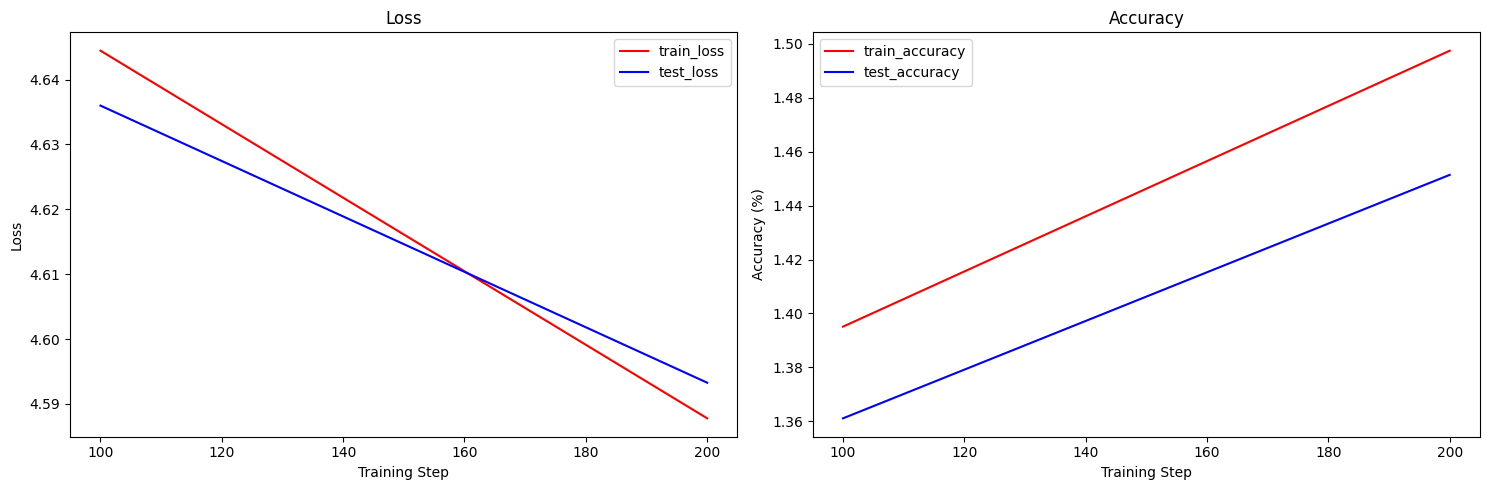

  3%|▎         | 285/10000 [1:42:16<57:37:27, 21.35s/it]

In [ ]:
# ---- Real-time plotting ----

metrics_history = {
    'train_loss': [],
    'train_accuracy': [],
    'test_loss': [],
    'test_accuracy': [],
    'steps': [] 
}

def get_subkeys(key):
    keys = random.split(key, GLOBAL_BATCH_SIZE // MICRO_BATCH_SIZE + 1)
    return keys[0], keys[1:]


with mesh:
    # Main training loop
    for step in tqdm(range(train_steps)):
        
        # Load data for the first micro-batch and stacked micro-batches for gradient accumulation
        key, subkeys = get_subkeys(key) 
        x, y = data_load(train, MICRO_BATCH_SIZE, CONTEXT_SIZE, subkeys[0])
        xs, ys = zip(*(data_load(train, MICRO_BATCH_SIZE, CONTEXT_SIZE, k) for k in subkeys[1:]))
        x_stack, y_stack = jnp.stack(xs), jnp.stack(ys)
        train_step(model, optimizer, metrics, x, y, x_stack, y_stack)

        # Periodic evaluation and metric logging
        if step > 0 and (step % eval_every == 0 or step == train_steps - 1):  
            # Log the training metrics.
            for metric, value in metrics.compute().items():  # Compute the metrics.
                metrics_history[f'train_{metric}'].append(value)  # Record the metrics.
            metrics.reset()  # Reset the metrics for the test set.
    
            # Compute the metrics on the test set 
            for _ in range(10):
                key, subkey = random.split(key, 2)
                x,y = data_load(test, MICRO_BATCH_SIZE, CONTEXT_SIZE, subkey)
                eval_step(model, metrics, x, y)
    
            # Log the test metrics.
            for metric, value in metrics.compute().items():
                metrics_history[f'test_{metric}'].append(value)
            metrics.reset()  # Reset the metrics 
    
            # Record the step number for the x-axis
            metrics_history['steps'].append(step)
    
            '''
            print(
              f"[train] step: {step}, "
              f"loss: {metrics_history['train_loss'][-1]}, "
              f"accuracy: {metrics_history['train_accuracy'][-1] * 100}"
            )
            print(
              f"[test] step: {step}, "
              f"loss: {metrics_history['test_loss'][-1]}, "
              f"accuracy: {metrics_history['test_accuracy'][-1] * 100}"
            )
            '''
            
            # --- Update the plot for Kaggle ---
            # Clear previous output and redraw plots for live update
            clear_output(wait=True) # Clear the previous output of the storage cell, wait=True to avoid flickering
    
            # Recreate the chart and axes each time
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
            ax1.set_title('Loss')
            ax1.set_xlabel('Training Step')
            ax1.set_ylabel('Loss')
            ax2.set_title('Accuracy')
            ax2.set_xlabel('Training Step')
            ax2.set_ylabel('Accuracy (%)')
    
            ax1.plot(metrics_history['steps'], metrics_history['train_loss'], 'r-', label='train_loss')
            ax1.plot(metrics_history['steps'], metrics_history['test_loss'], 'b-', label='test_loss')
            ax2.plot(metrics_history['steps'], [acc * 100 for acc in metrics_history['train_accuracy']], 'r-', label='train_accuracy')
            ax2.plot(metrics_history['steps'], [acc * 100 for acc in metrics_history['test_accuracy']], 'b-', label='test_accuracy')
    
            ax1.legend()
            ax2.legend()
            plt.tight_layout() # Adjust layout to avoid overlap
            display(fig) # Display the chart in the Notebook
            plt.close(fig) # Close the chart object to free up memory and avoid displaying it twice


print("Training finished.")

# Plot

In [ ]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train', 'test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()

# Summary of Key Techniques

- **FP16 Mixed Precision:** All model weights and activations use `bfloat16` to reduce memory usage and speed up computation.
- **Gradient Accumulation:** Gradients are accumulated over several micro-batches before updating, enabling large effective batch sizes.
- **Activation Recomputation:** Intermediate activations are recomputed during the backward pass to save memory.
- **Tensor and Sequence Parallelism:** Model weights and computation are partitioned across multiple TPU devices, allowing for efficient large-scale training.

These techniques together enable training of large language models efficiently on TPU clusters.